[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [4]:
from langchain_aws import ChatBedrock, ChatBedrockConverse   
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatBedrockConverse(model_id="us.amazon.nova-pro-v1:0", temperature=0,disable_streaming='tool_calling')
#llm = ChatBedrock(model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0", temperature=0)


# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools)

In [5]:
llm_with_tools.invoke("Please call the first tool two times").tool_calls

[{'name': 'add',
  'args': {'a': 1, 'b': 2},
  'id': 'tooluse_r3oC2s-tSiOLxNSOzbbWww',
  'type': 'tool_call'},
 {'name': 'add',
  'args': {'a': 3, 'b': 4},
  'id': 'tooluse_XNckELbDRWi3rpnBtbA1Fw',
  'type': 'tool_call'}]

Let's create our LLM and prompt it with the overall desired agent behavior.

In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

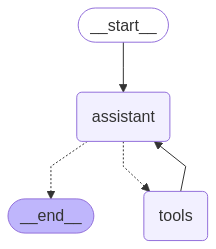

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> To solve the problem, I need to follow these steps:\n1. Add 3 and 4.\n2. Multiply the result by 2.\n3. Divide the result by 5. </thinking>\n'}, {'type': 'tool_use', 'name': 'add', 'input': {'a': 3, 'b': 4}, 'id': 'tooluse_VqIrpM_zTX6PZxnSBrblog'}]
Tool Calls:
  add (tooluse_VqIrpM_zTX6PZxnSBrblog)
 Call ID: tooluse_VqIrpM_zTX6PZxnSBrblog
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

[{'type': 'text', 'text': '<thinking> The result of adding 3 and 4 is 7. Next, I need to multiply this result by 2. </thinking> '}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 7, 'b'

## LangSmith

We can look at traces in LangSmith.